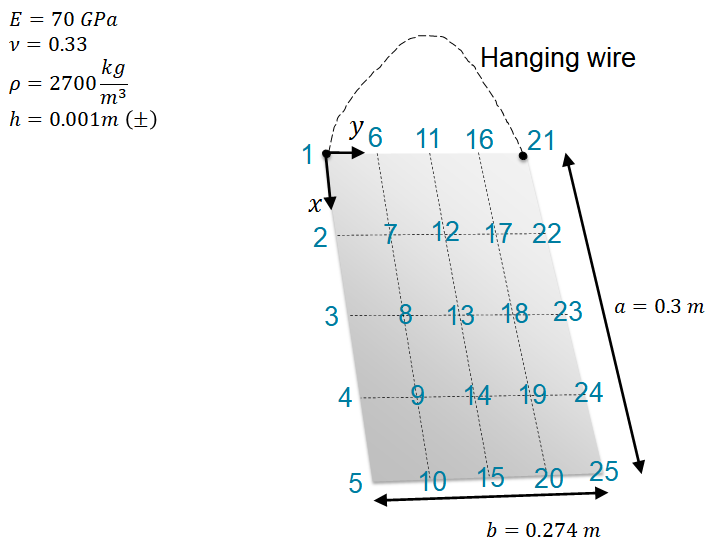

In [ ]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi
from scipy.linalg import cholesky, eigh
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF

def mag2db(mag):
    return 20*np.log10(mag)


nx = 25
ny = 25

a = 0.300 # [m]
b = 0.274 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.001 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

acc_pos05 = np.where(np.isclose(x, a) & np.isclose(y, 0))[0][0]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

plate = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True)

N = DOF*nx*ny
K = np.zeros((N, N))
M = np.zeros((N, N))
quads = []

for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.rho = rho
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = h
    quad.A = plate.A
    quad.B = plate.B
    quad.D = plate.D
    quad.Atrans = plate.Atrans
    update_K(quad, nid_pos, ncoords, K)
    update_M(quad, nid_pos, ncoords, M)
    quads.append(quad)

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True


m_acc = 0.001
M[acc_pos05*DOF+0, acc_pos05*DOF+0] += m_acc
M[acc_pos05*DOF+1, acc_pos05*DOF+1] += m_acc
M[acc_pos05*DOF+2, acc_pos05*DOF+2] += m_acc

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]

L = cholesky(Muu, lower=True)
Linv = np.linalg.inv(L)
Ktilde = Linv @ Kuu @ Linv.T

rbmodes = 3
Nmodes = 25
gamma, V = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
print('all omegan', gamma[:10]**0.5)
V = V[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

P = V


zeta = 0.02

omegad = omegan*np.sqrt(1 - zeta**2)

print('omegan [Hz]', omegan/(2*pi))
print('omegad [Hz]', omegad/(2*pi))


C:\Users\jsodja\AppData\Local\Temp\ipykernel_21408\420156943.py:104: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  gamma, V = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1


all omegan [          nan           nan           nan  246.10955177  353.64181628
  470.52593118  620.50282536  669.05571591 1051.34756586 1183.10758498]
omegan [Hz] [ 39.16955171  56.28384315  74.8865278   98.75609186 106.48352439
 167.32716201 188.29742036 200.98655222 203.73511774 235.94870138
 308.81612643 327.87322965 334.28924472 368.27720927 401.40696755
 429.35128986 468.14497712 487.65316973 528.55374096 563.36569009
 592.27622111 607.19870913]
omegad [Hz] [ 39.16171701  56.27258525  74.871549    98.73633866 106.46222556
 167.29369323 188.25975711 200.94635089 203.69436664 235.90150692
 308.75435702 327.80764844 334.22238019 368.20354646 401.32667813
 429.26541101 468.05133876 487.55562934 528.44801964 563.25300569
 592.15775401 607.07725724]


C:\Users\jsodja\AppData\Local\Temp\ipykernel_21408\420156943.py:105: RuntimeWarning: invalid value encountered in sqrt
  print('all omegan', gamma[:10]**0.5)


omega1 39.16955170698022


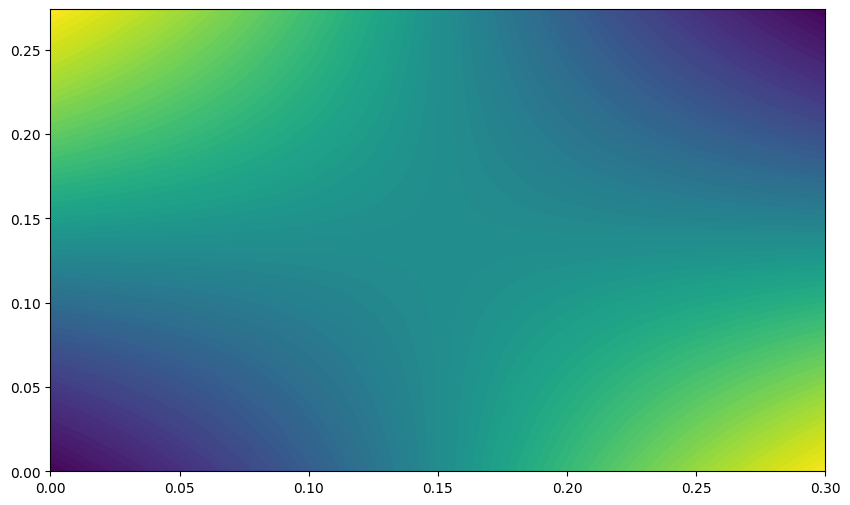

In [2]:
mode = 0
Uu = (Linv.T @ V[:, mode])
U = np.zeros(K.shape[0])
U[bu] = Uu
plt.contourf(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=100)
print('omega1', omegan[mode]/(2*pi))


Hammer Impact Parameters
---

In [3]:
tmax = 1.953
Nsamples = 2**16

t = np.linspace(0, tmax, Nsamples)
dt = t[1] - t[0]
Nsamples = t.size
print('Nsamples', Nsamples)

ximpact = a/4
yimpact = 3*b/4

hammer = np.zeros_like(t)
impulse = 0.021871147552536902
ind = 10
step = t[ind]
hammer[:ind+1] = -impulse/step

print('force', impulse/step)


Nsamples 65536
force 73.39097055071714


Simulating Impact Hammer Test
---

In [4]:
# dynamic analysis

on = omegan[:, None]
od = omegad[:, None]

# convolution integral: general load as a sequence of impulse loads
def r_t(t, t1, t2, on, zeta, od, fmodaln):
    tn = (t1 + t2)/2
    dt = t2 - t1
    # damped function
    H = np.heaviside(t - tn, 1.)
    h = np.zeros((Nmodes-rbmodes, t.shape[0]))
    check = t >= tn
    h[:, check] = 1/od*np.exp(-zeta*on*(t[check] - tn))*np.sin(od*(t[check] - tn))*H[check]
    
    return fmodaln*dt*h

def rdotdot_t(t, t1, t2, on, zeta, od, fmodaln):
    tn = (t1 + t2)/2
    dt = t2 - t1
    # damped function
    H = np.heaviside(t - tn, 1.)
    h = np.zeros((Nmodes-rbmodes, t.shape[0]))
    check = t >= tn
    h[:, check] = (-od*np.sin(od*(t[check] - tn)) - 2*on*zeta*np.cos(od*(t[check] - tn)) 
     + on**2*zeta**2*np.sin(od*(t[check] - tn))/od)*np.exp(-on*zeta*(t[check] - tn))
    
    return fmodaln*dt*h


f = np.zeros(N)

responses = {}
u = np.zeros((N, len(t)))
acc = np.zeros((N, len(t)))

print('point of impact:', ximpact, yimpact)
force_pos = np.where(np.isclose(x, ximpact) & np.isclose(y, yimpact))[0][0]

f[:] = 0
f[DOF*force_pos+2] += hammer[0]

# calculating modal forces
fmodaln = (P.T @ Linv @ f[bu])[:, None]

# assuming only particular solution
r = r_t(t, 0, step, on, zeta, od, fmodaln)

# assuming only particular solution
rdotdot = rdotdot_t(t, 0, step, on, zeta, od, fmodaln)

# transforming from r-space to displacement and acceleration
u[bu] = Linv.T @ P @ r
acc[bu] = Linv.T @ P @ rdotdot

response_u = u[DOF*acc_pos05+2].copy()
response = acc[DOF*acc_pos05+2].copy()/9.81


point of impact: 0.075 0.20550000000000002


Checking signals in frequency domain
---

Text(0, 0.5, 'acceleration [g/Hz]')

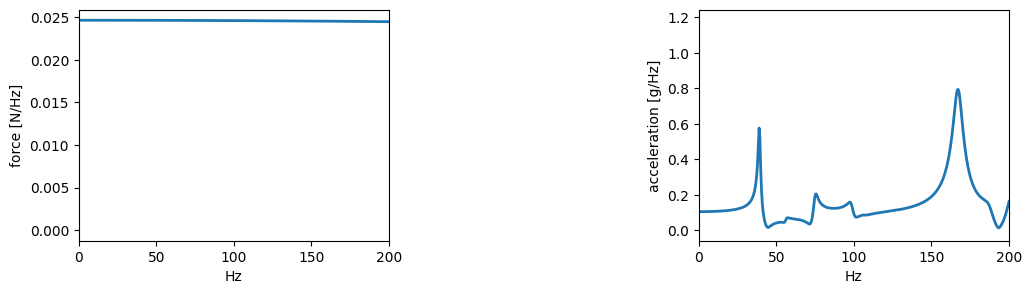

In [5]:
# Fast Fourier Transform to get the frequencies
freqs = np.fft.rfftfreq(Nsamples, dt)
xf = np.fft.rfft(hammer)/(Nsamples//2)
yf = np.fft.rfft(response)/(Nsamples//2)

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))
plt.subplots_adjust(wspace=1)
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 200)
axes[0].plot(freqs, np.abs(xf))
axes[0].set_xlabel('Hz')
axes[0].set_ylabel('force [N/Hz]')
axes[1].plot(freqs, np.abs(yf))
axes[1].set_xlabel('Hz')
axes[1].set_ylabel('acceleration [g/Hz]')

Frequency Response Function
--

(0.2, 30)

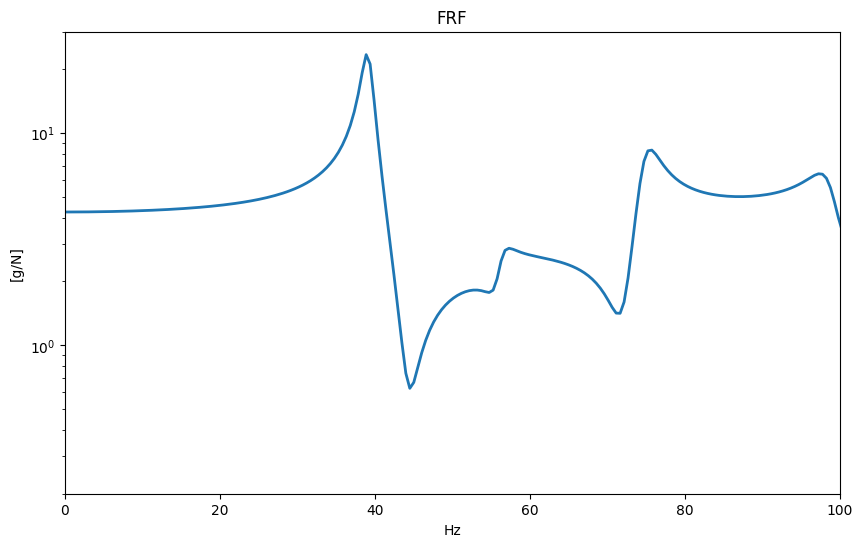

In [6]:
pxx = np.conj(xf)*xf 
pxy = np.conj(xf)*yf 
H = np.zeros_like(pxx)
check = ~np.isclose(pxx, 0+0j)
H[check] = pxy[check]/pxx[check]
plt.semilogy(freqs, np.abs(H))
plt.ylabel('[g/N]')
plt.xlabel('Hz')
plt.title('FRF')
plt.xlim(0, 100)
plt.ylim(0.2, 30)

FRF real
---

246.10955177410924


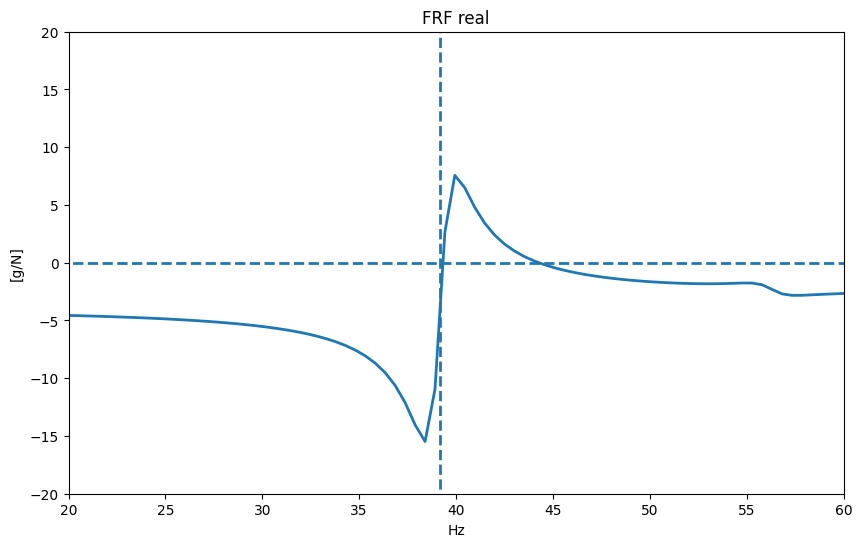

In [7]:
plt.plot(freqs, H.real)
plt.ylabel('[g/N]')
plt.xlabel('Hz')
plt.title('FRF real')
plt.xlim(20, 60)
plt.ylim(-20, 20)
plt.vlines(x=omegan[0]/2/pi, ymin=-40, ymax=40, ls='--')
plt.hlines(y=0, xmin=0, xmax=100, ls='--')
print(omegan[0])

FRF imag
---

(-30.0, 30.0)

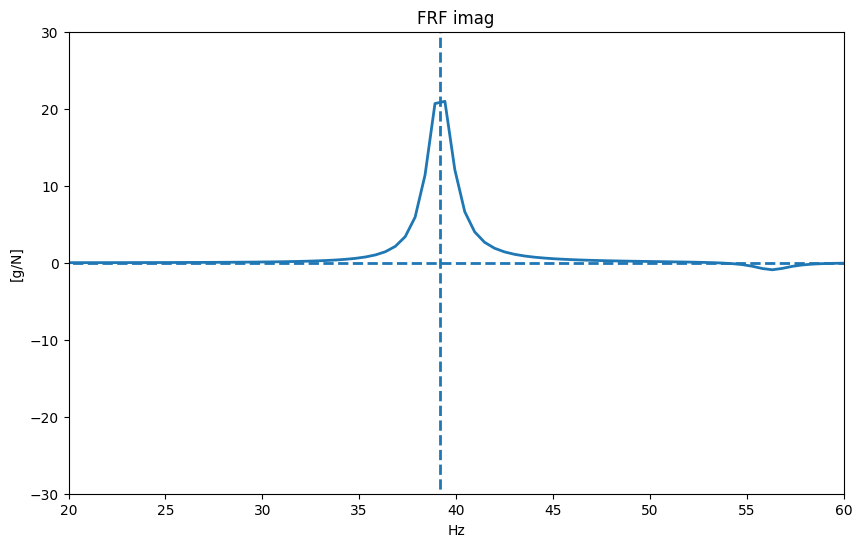

In [8]:
plt.plot(freqs, H.imag)
plt.ylabel('[g/N]')
plt.xlabel('Hz')
plt.title('FRF imag')
plt.vlines(x=omegan[0]/2/pi, ymin=-40, ymax=40, ls='--')
plt.hlines(y=0, xmin=0, xmax=100, ls='--')
plt.xlim(20, 60)
plt.ylim(-30, 30)